# Gradient Boosting

### http://blog.csdn.net/han_xiaoyang/article/details/52663170

- Boosting算法对同时控制bias和variance都有非常好的效果，而且更加高效。
- Boosting可以将一系列弱学习因子（weak learners）相结合来提升总体模型的预测准确度。在任意时间t，根据t-1时刻得到的结果我们给当前结果赋予一个权重。之前正确预测的结果获得较小权重，错误分类的结果得到较大权重。
- Adaboost 強化版



### GBM的参数可以被归为三类：

- Tree parameter：调节模型中每个决定树的性质
- Boosting参数：调节模型中boosting的操作
- 其他模型参数：调节模型总体的各项运作




### 參數定義參考 GBM parameter.xlsx

# (A) Tree Parameters

### 1. min_ samples_split
- 定义了树中一个节点所需要用来分裂的最少样本数。
- 可以避免过度拟合(over-fitting)。如果用于分类的样本数太小，模型可能只适用于用来训练的样本的分类，而用较多的样本数则可以避免这个问题。
- 但是如果设定的值过大，就可能出现欠拟合现象(under-fitting)。因此我们可以用CV值（离散系数）考量调节效果。

### 2.min_ samples_leaf
- 定义了树中终点节点所需要的最少的样本数。
- 同样，它也可以用来防止过度拟合。
- 在不均等分类问题中(imbalanced class problems)，一般这个参数需要被设定为较小的值，因为大部分少数类别（minority class）含有的样本都比较小。

### 3.min_ weight_ fraction_leaf
- 和上面min_ samples_ leaf很像，不同的是这里需要的是一个比例而不是绝对数值：终点节点所需的样本数占总样本数的比值。
- #2和#3只需要定义一个就行了

### 4.max_ depth
- 定义了树的最大深度。
- 它也可以控制过度拟合，因为分类树越深就越可能过度拟合。
- 当然也应该用CV值检验。

### 5.max_ leaf_ nodes
- 定义了决定树里最多能有多少个终点节点。
- 这个属性有可能在上面max_ depth里就被定义了。比如深度为n的二叉树就有最多2^n个终点节点。
- 如果我们定义了max_ leaf_ nodes，GBM就会忽略前面的max_depth。

### 6.max_ features
- 决定了用于分类的特征数，是人为随机定义的。
- 根据经验一般选择总特征数的平方根就可以工作得很好了，但还是应该用不同的值尝试，最多可以尝试总特征数的30%-40%.
- 过多的分类特征可能也会导致过度拟合。


# (B) Boosting Parameters

### 1.learning_ rate
- 这个参数决定着每一个决定树对于最终结果（步骤2.4）的影响。GBM设定了初始的权重值之后，每一次树分类都会更新这个值，而learning_ rate控制着每次更新的幅度。
- 一般来说这个值不应该设的比较大，因为较小的learning rate使得模型对不同的树更加稳健，就能更好地综合它们的结果。

### 2.n_ estimators
- 定义了需要使用到的决定树的数量（步骤2）
- 虽然GBM即使在有较多决定树时仍然能保持稳健，但还是可能发生过度拟合。所以也需要针对learning rate用CV值检验。

### 3.subsample

- 训练每个决定树所用到的子样本占总样本的比例，而对于子样本的选择是随机的。
- 用稍小于1的值能够使模型更稳健，因为这样减少了Variance。
- 一把来说用~0.8就行了，更好的结果可以用调参获得。



# (C) Others

### 1.loss

- 指的是每一次节点分裂所要最小化的损失函数(loss function)
- 对于分类和回归模型可以有不同的值。一般来说不用更改，用默认值就可以了，除非你对它及它对模型的影响很清楚。

### 2.init
- 它影响了输出参数的起始化过程
- 如果我们有一个模型，它的输出结果会用来作为GBM模型的起始估计，这个时候就可以用init

### 3.random_ state
- 作为每次产生随机数的随机种子
- 使用随机种子对于调参过程是很重要的，因为如果我们每次都用不同的随机种子，即使参数值没变每次出来的结果也会不同，这样不利于比较不同模型的结果。
- 任一个随即样本都有可能导致过度拟合，可以用不同的随机样本建模来减少过度拟合的可能，但这样计算上也会昂贵很多，因而我们很少这样用

### 4.verbose
- 决定建模完成后对输出的打印方式：

0：不输出任何结果（默认）

1：打印特定区域的树的输出结果

\>1：打印所有结果

### 5.warm_ start
- 这个参数的效果很有趣，有效地使用它可以省很多事
- 使用它我们就可以用一个建好的模型来训练额外的决定树，能节省大量的时间，对于高阶应用我们应该多多探索这个选项。

### 6.presort
- 决定是否对数据进行预排序，可以使得树分裂地更快。
- 默认情况下是自动选择的，当然你可以对其更改


## Example data 為 binary target

In [5]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier  #GBM algorithm
from sklearn.model_selection import cross_validate
from sklearn import metrics   #Additional scklearn functions
from sklearn.model_selection import GridSearchCV  #Perforing grid search


import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

train = pd.read_csv('data/train_modified.csv')
target = 'Disbursed'
IDcol = 'ID'

In [18]:
def modelfit(alg,dtrain,predictors,performCV = True,printFeatureImportance = True,cv_folds = 5):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors],dtrain['Disbursed'])
    
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_validate(alg,dtrain[predictors],dtrain['Disbursed'],cv = cv_folds,scoring = 'roc_auc')
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Disbursed'].values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob))
    

    if performCV:
        print ("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score['test_score']),np.std(cv_score['test_score']),np.min(cv_score['test_score']),np.max(cv_score['test_score'])))

     #Print Feature Importance:
    
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_,predictors).sort_values(ascending = False)
        feat_imp.plot(kind = 'bar',title = 'Feature Importances')
        plt.ylabel('Feature Importance Score')


Model Report
Accuracy : 0.9856
AUC Score (Train): 0.862264
CV Score : Mean - 0.831884 | Std - 0.009558427 | Min - 0.8195451 | Max - 0.8438424


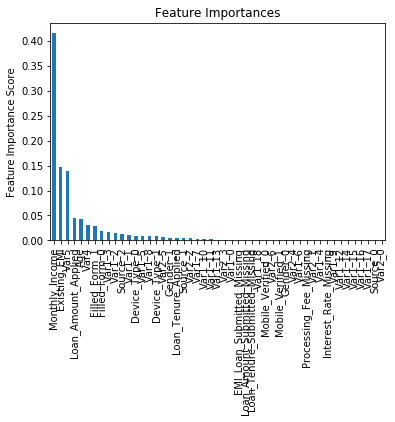

In [19]:
#Choose all predictors except target & IDcols

predictors = [x for x in train.columns if x not in [target,IDcol]]
gbm0 = GradientBoostingClassifier(random_state = 10)
modelfit(gbm0,train,predictors)

##  Parameter Tuning

- learning rate没有什么特别的调节方法，因为只要我们训练的树足够多learning rate总是小值来得好
- 需要注意一下调参顺序，对结果影响最大的参数应该优先调节，就像max_depth和num_samples_split

先固定 learning rate
- 1.调节max_depth和 num_samples_split
- 2.调节min_samples_leaf
- 3.调节max_features

其他參數固定後

降低learning_rate  同時提高n_estimators

In [21]:
feat_imp = pd.Series(gbm0.feature_importances_,predictors)
feat_imp

Existing_EMI                     0.147353
Loan_Amount_Applied              0.044694
Loan_Tenure_Applied              0.005447
Monthly_Income                   0.414832
Var4                             0.030264
Var5                             0.138212
Age                              0.042675
EMI_Loan_Submitted_Missing       0.001063
Interest_Rate_Missing            0.000000
Loan_Amount_Submitted_Missing    0.001029
Loan_Tenure_Submitted_Missing    0.000935
Processing_Fee_Missing           0.000000
Device_Type_0                    0.008973
Device_Type_1                    0.008797
Filled_Form_0                    0.018424
Filled_Form_1                    0.028303
Gender_0                         0.000380
Gender_1                         0.005541
Var1_0                           0.001267
Var1_1                           0.011098
Var1_2                           0.013893
Var1_3                           0.017276
Var1_4                           0.000000
Var1_5                           0

## 模行調校 ....

- 固定learning_rate
- gridsearch 找n_estimator
- 调节max_depth和 num_samples_split
- 调节min_samples_leaf
- 调节max_features
- subsamples
- 調低learning_rate 同時增加 n_estimator